In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

LC405 data

In [2]:
# Load the data
db1_read = pd.read_csv('data/P_LC405_wlp3s0_100_2024_05_03-08_39_34_AM.csv')
db2_read = pd.read_csv('data/P_LC405_wlp3s0_100_2024_05_03-08_52_49_AM.csv')
db3_read = pd.read_csv('data/P_LC405_wlp3s0_100_2024_05_03-09_06_19_AM.csv')
db4_read = pd.read_csv('data/P_LC405_wlp3s0_100_2024_05_03-09_19_15_AM.csv')


In [3]:
db1 = copy.deepcopy(db1_read)
db2 = copy.deepcopy(db2_read)
db3 = copy.deepcopy(db3_read)
db4 = copy.deepcopy(db4_read)
db = pd.concat([db1, db2, db3, db4])


Full data

In [4]:
# Load the data
db_read = pd.read_csv('../Mesures/data03.csv')

In [5]:
db = copy.deepcopy(db_read)

In [6]:
nb_samples = len(db)
print("number of samples: ", nb_samples)

not_mac_columns = db.columns[~db.columns.str.contains(":")]
print("not mac columns: ", not_mac_columns)
db_mac = db.loc[:, ~db.columns.isin(not_mac_columns)]
nb_mac = len(db_mac.columns)
print("number of mac addresses: ", nb_mac)


number of samples:  25223
not mac columns:  Index(['timestamp', 'room', 'device_id', 'door_status', 'room_part'], dtype='object')
number of mac addresses:  610


Selecting one position

In [7]:
room = "LC414"
pos = 1
pc = "V"

db = db[db['room'] == room]
db = db[db['room_part'] == pos]
db = db[db['device_id'] == pc]

print("IN POSITION ", pos, " IN ROOM ", room, " FOR PC ", pc)
nb_samples = len(db)
print("number of samples: ", nb_samples)
not_mac_columns = db.columns[~db.columns.str.contains(":")]
print("not mac columns: ", not_mac_columns)
db_mac = db.loc[:, ~db.columns.isin(not_mac_columns)]
nb_mac = len(db_mac.columns)
print("number of mac addresses: ", nb_mac)

IN POSITION  1  IN ROOM  LC414  FOR PC  V
number of samples:  95
not mac columns:  Index(['timestamp', 'room', 'device_id', 'door_status', 'room_part'], dtype='object')
number of mac addresses:  610


In [8]:
# Calculate the porcentage of nan values to each MAC address
nan_values_pctage = db_mac.isnull().sum(axis=0)/nb_samples*100
positions = np.argsort(nan_values_pctage)
nan_values_pctage = nan_values_pctage[positions]
db_mac = db_mac.iloc[:,positions]

perfect_macs = db_mac.loc[:,nan_values_pctage<1]
print(perfect_macs.shape[1], "mac addresses have less than 1% missing values")



21 mac addresses have less than 1% missing values


/tmp/ipykernel_42634/521835389.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nan_values_pctage = nan_values_pctage[positions]


In [9]:
from sklearn.mixture import GaussianMixture
from scipy.stats import t
from scipy.stats import norm
from scipy.stats import probplot

def positive_values(data, min_value):
    return data-min_value

def exponential_values(data, min_value, alpha):
    pos = positive_values(data, min_value)
    return np.exp(pos/alpha)/np.exp(-min_value/alpha)

def powed_values(data, min_value, beta):
    pos = positive_values(data, min_value)
    return np.power(pos,beta)/np.power(-min_value, beta)

def GaussianMixturePDF(x, means, variance, weights):
    return (weights[0]*np.exp(-(x-means[0])**2/(2*variance)) + weights[1]*np.exp(-(x-means[1])**2/(2*variance)))/np.sqrt(2*np.pi*variance)

def GaussianMixtureCDF(x, means, variance, weights):
    return weights[0]*norm.cdf(x, means[0], np.sqrt(variance)) + weights[1]*norm.cdf(x, means[1], np.sqrt(variance))

def GaussianMixturePlot(data, x1, x2, nb_bins):
    x = np.linspace(x1, x2, 200)
    # Gaussian mixture model
    gmm = GaussianMixture(n_components=2, covariance_type='tied')
    gmm.fit(data.reshape(-1,1))
    means = gmm.means_
    variance = gmm.covariances_
    weights = gmm.weights_
    plt.plot(x, GaussianMixturePDF(x,means,variance,weights).T, color='mediumvioletred')
    # Histogram
    plt.hist(data, bins=np.linspace(x1,x2, nb_bins), color='b',density=True)
    
def GaussianPlot(data, x1, x2, nb_bins):
    x = np.linspace(x1, x2, 200)
    # Gaussian fit
    mean = np.mean(data)
    std = np.std(data)
    y = t.pdf((x-mean)/std, nb_samples-1)/std
    plt.plot(x,y, color='darkorange')
    # Histogram
    plt.hist(data, bins=np.linspace(x1,x2, nb_bins), color='b',density=True)
    
def QQplotGaussianMixture(data, x1, x2, nb_bins):
    x = np.linspace(x1, x2, 200)
    # Gaussian mixture model
    gmm = GaussianMixture(n_components=2, covariance_type='tied')
    gmm.fit(data.reshape(-1,1))
    means = gmm.means_
    variance = gmm.covariances_
    weights = gmm.weights_
    # QQ plot
    plt.scatter(np.sort(data), GaussianMixtureCDF(np.sort(data),means,variance,weights).T*(x2-x1), color='mediumvioletred')
    plt.plot([x1,x2],[x1,x2], color='blue')
    
def QQplotGaussian(data, x1, x2, nb_bins):
    x = np.linspace(x1, x2, 200)
    # Gaussian fit
    mean = np.mean(data)
    std = np.std(data)
    y = t.pdf((x-mean)/std, nb_samples-1)/std
    plt.plot(x,y, color='darkorange')
    # QQ plot
    probplot(data, dist='t', sparams=(nb_samples-1), plot=plt)
    plt.scatter(np.sort(data), norm.cdf(np.sort(data), mean, std)*(x2-x1), color='darkorange')
    plt.plot([x1,x2],[x1,x2], color='blue')
    

Comparing probability models

/home/rick/.local/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


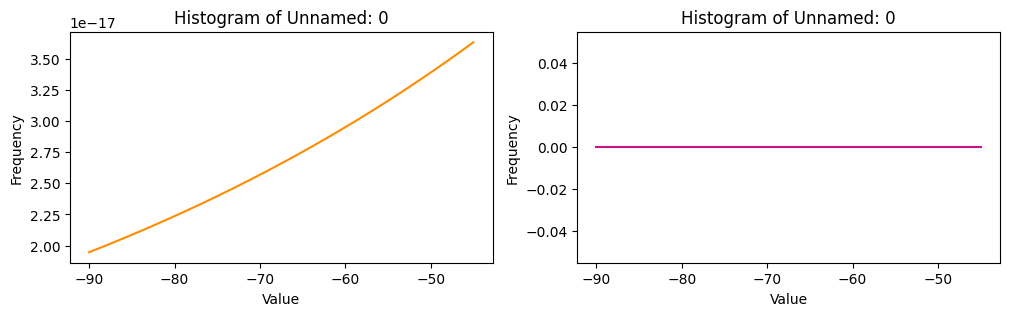

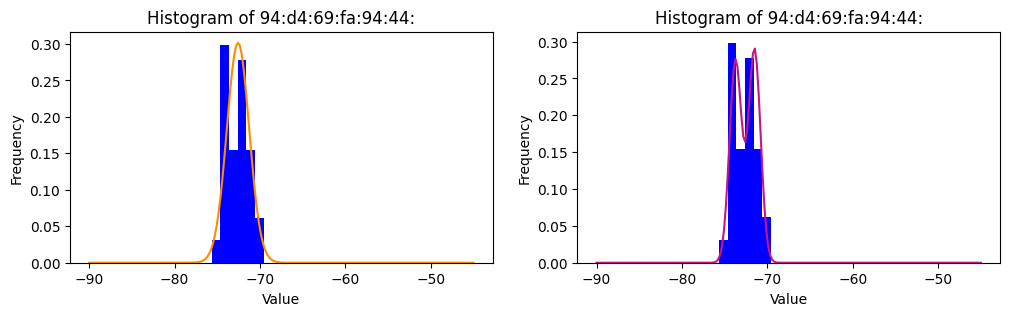

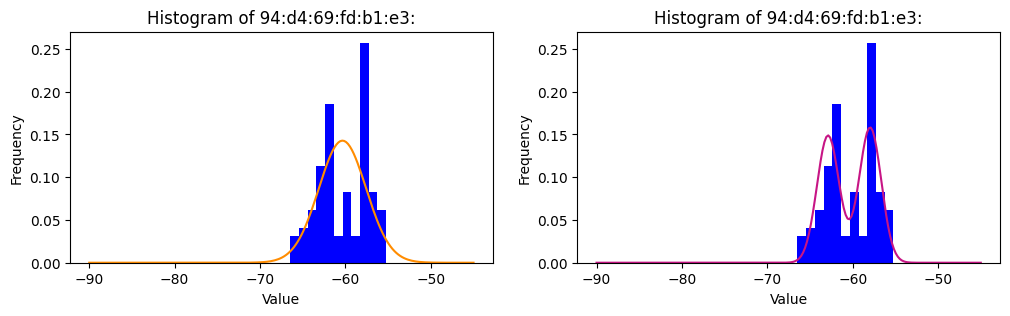

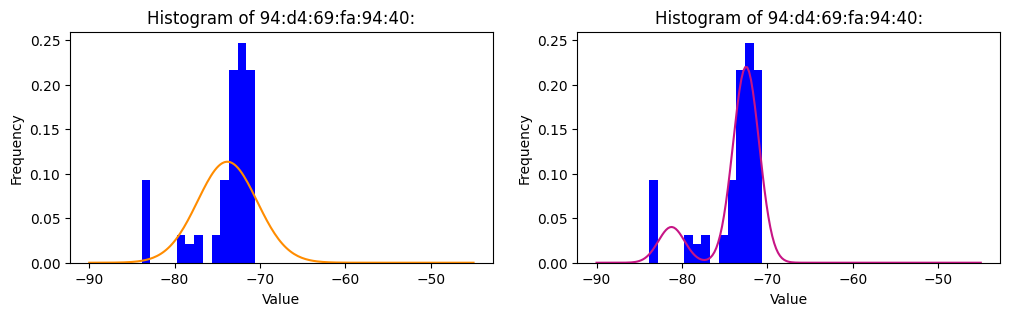

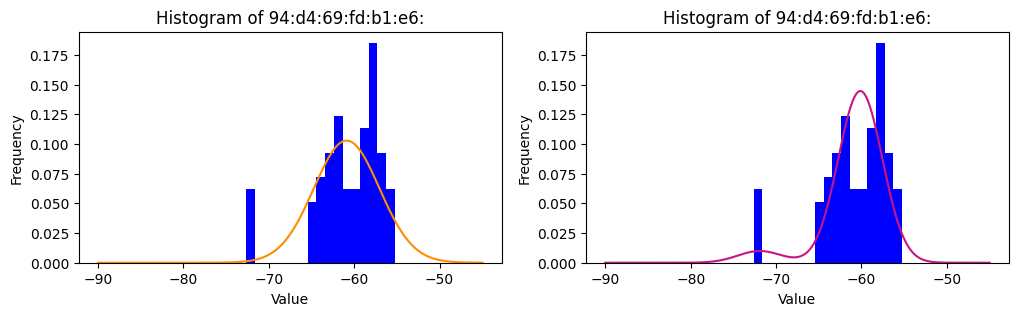

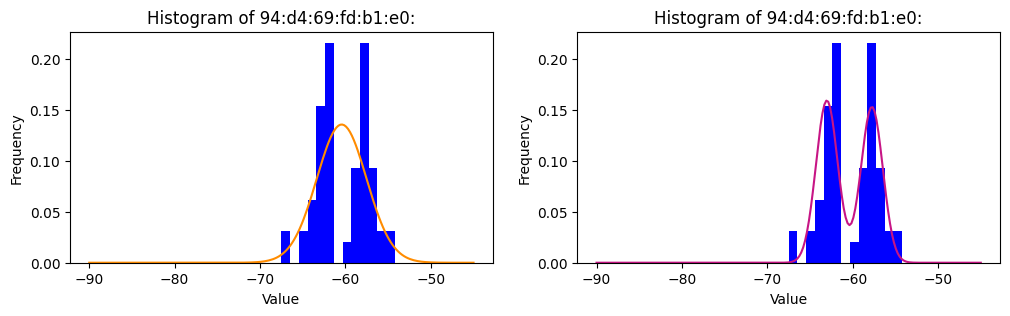

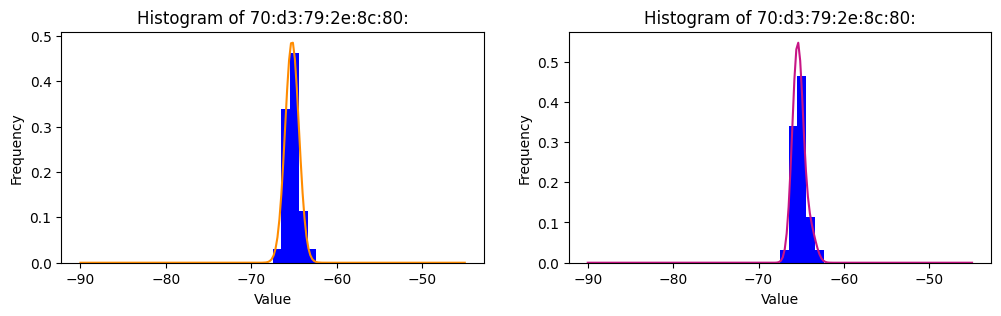

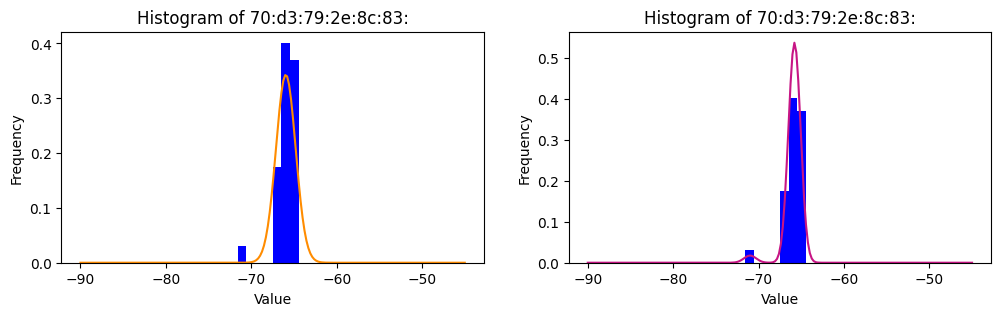

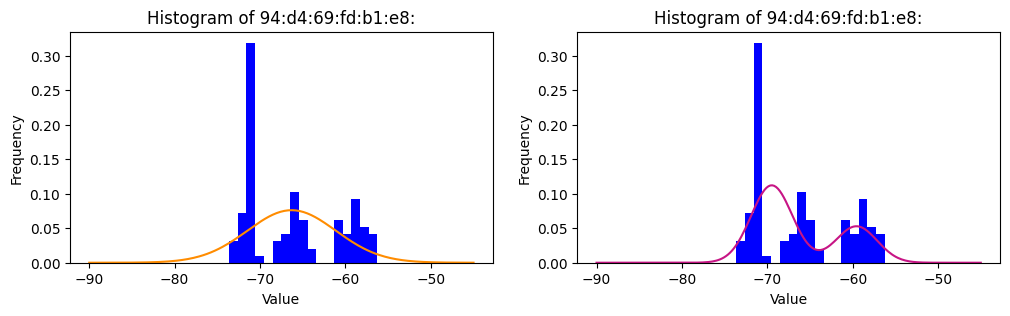

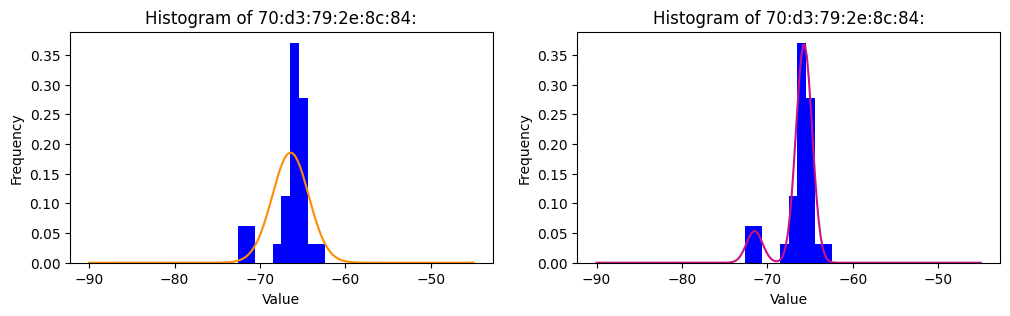

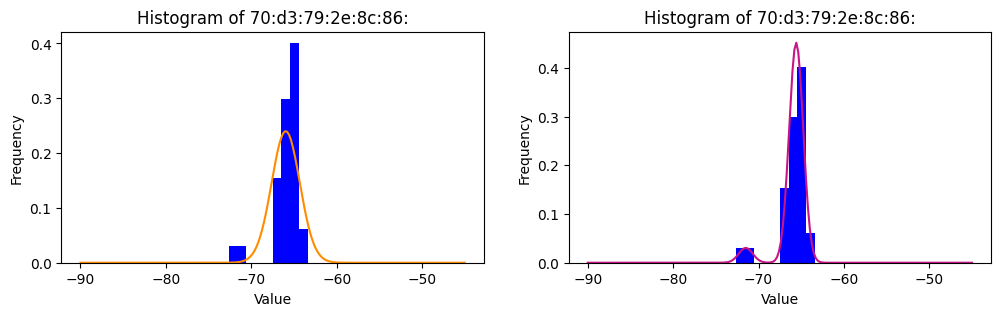

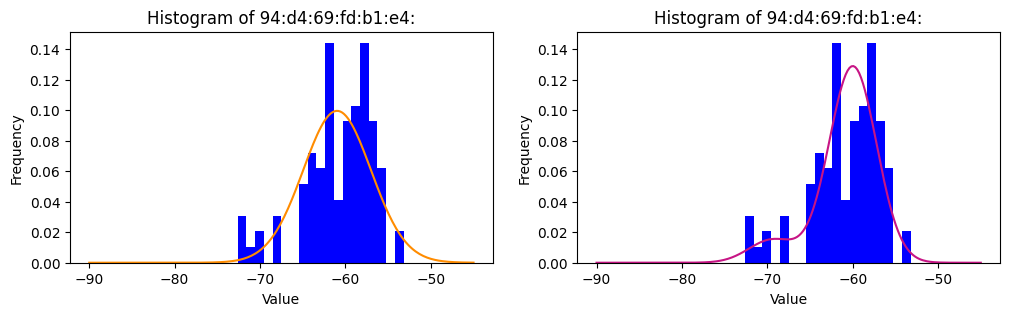

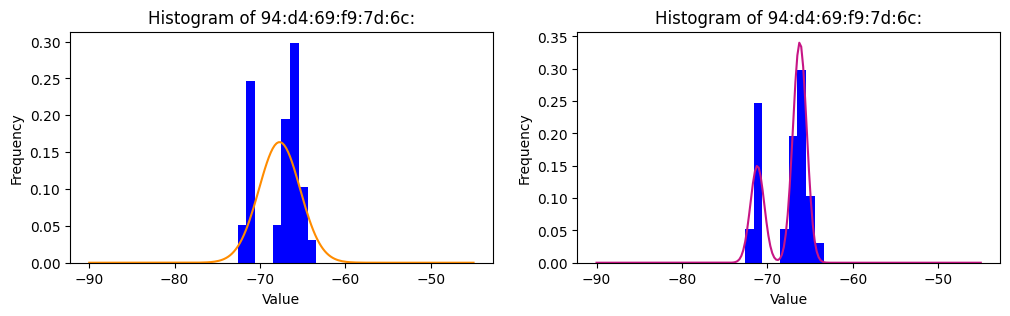

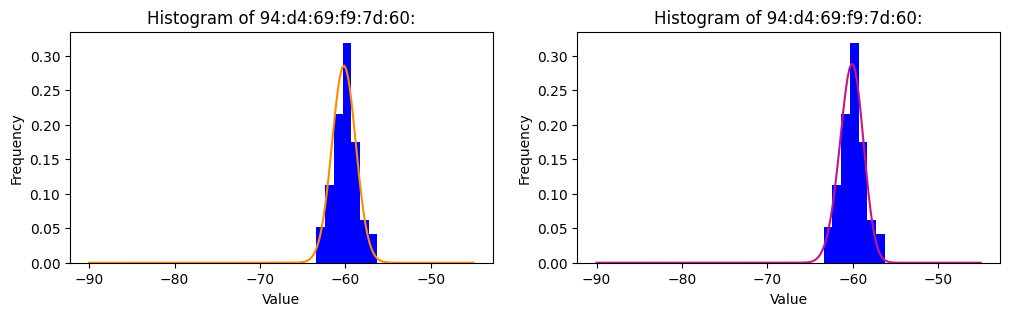

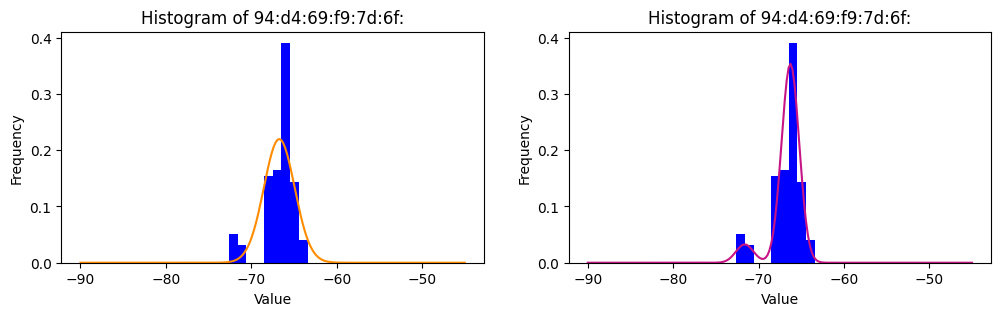

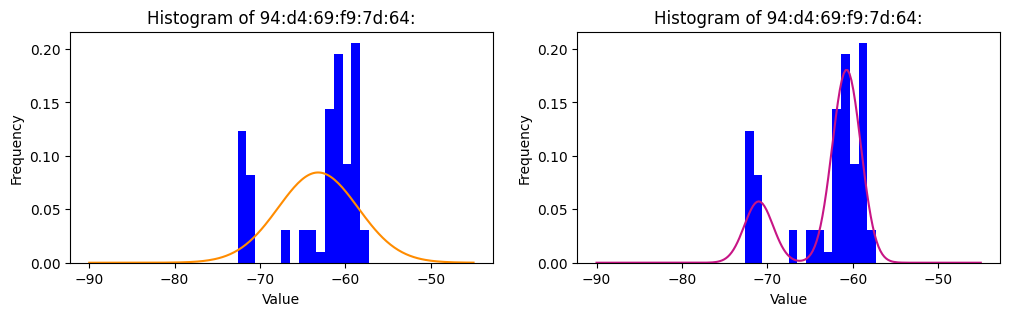

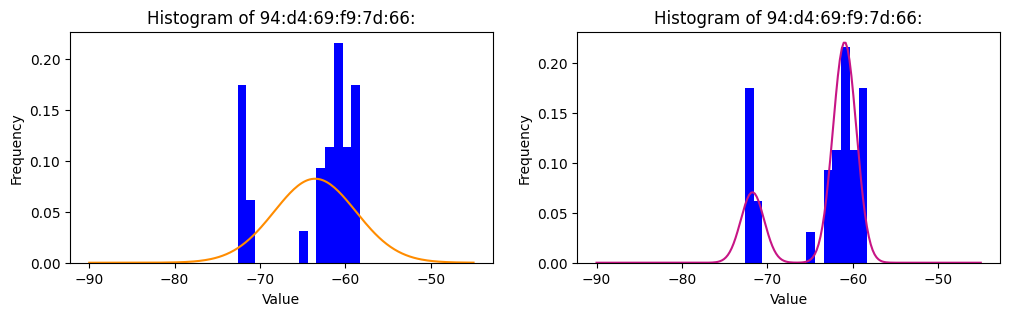

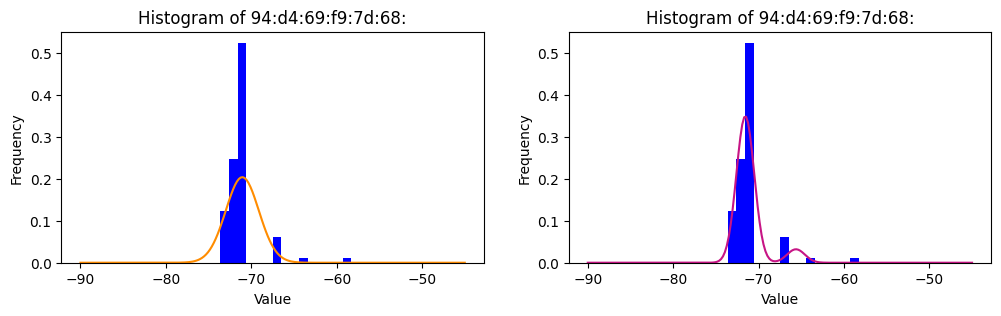

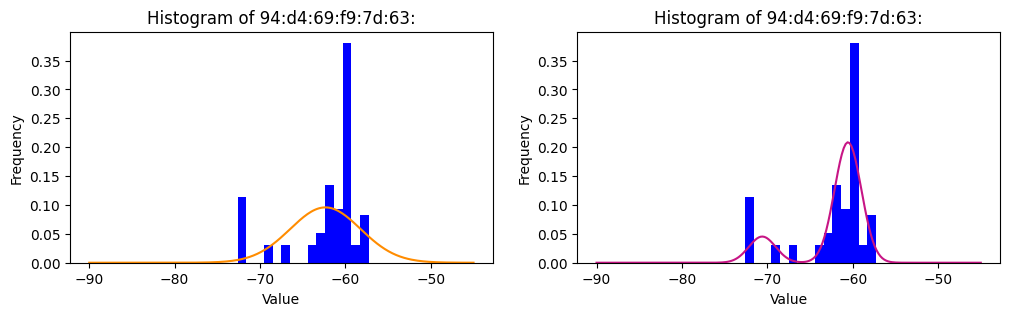

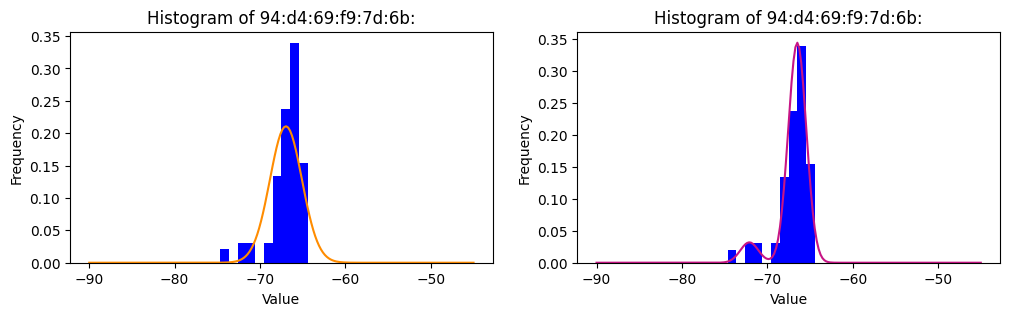

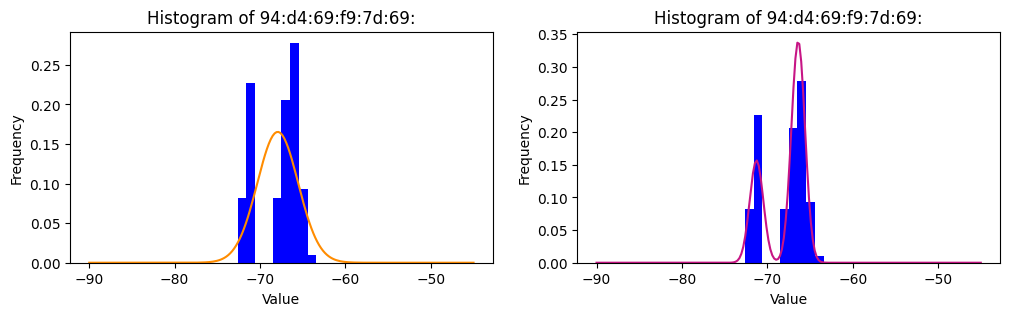

In [10]:
from scipy.stats import t
from sklearn.mixture import GaussianMixture
# x values for the normal distribution
x = np.linspace(-45, -95, 200)

for mac in perfect_macs.columns:
    plt.figure(figsize=(12,3))
    
    data = np.array(db[mac][db[mac].notna()].values)
    
    plt.subplot(1, 2, 2)
    # Gaussian mixture model
    GaussianMixturePlot(data, -90, -45, -45+90)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of {}'.format(mac))
    
    # plt.subplot(1, 4, 4)
    # # QQ plot
    # QQplotGaussianMixture(data, -90, -45, -45+90)
    
    plt.subplot(1, 2, 1)
    # Gaussian fit
    GaussianPlot(data, -90, -45, -45+90)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of {}'.format(mac))
    
    # plt.subplot(1, 4, 2)
    # # QQ plot
    # QQplotGaussian(data, -90, -45, -45+90)
    
    plt.show()
    
    """
    - estimar as medias de duas gaussianas somadas pela maximizacao da verossimilhanca
    - fazer transformação da representação dos valores
    - plotar tudo e comparar
    
    - procurar distribuição de probabilidade com mais momentos 
    - selecionar uns macs para apresentar
    - 
    
    
    - Q-Q plot entre as representações dos dados
    - Testar representações diferentes no t-loc
    - Testar modelo diferente no T-loc 
    
    """
    


comparing data representation

/tmp/ipykernel_42634/4294920139.py:11: RuntimeWarning: overflow encountered in divide
  return np.exp(pos/alpha)/np.exp(-min_value/alpha)
/tmp/ipykernel_42634/4294920139.py:15: RuntimeWarning: invalid value encountered in power
  return np.power(pos,beta)/np.power(-min_value, beta)
/home/rick/.local/lib/python3.10/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step


ValueError: Input X contains infinity or a value too large for dtype('float64').

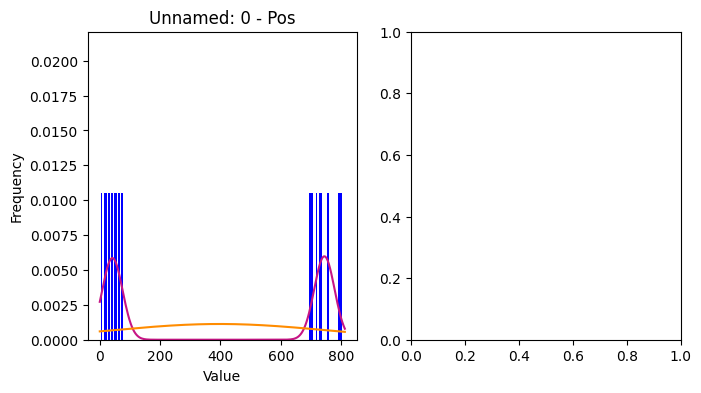

In [11]:
# x values 

for mac in perfect_macs.columns:
    plt.figure(figsize=(16,4))
    
    data = np.array(db[mac][db[mac].notna()].values)
    min_value = np.min(data)
    data_pos = positive_values(data, min_value)
    data_exp1 = exponential_values(data, min_value, 10/np.log(10))*1000000
    data_exp2 = exponential_values(data, min_value, 24)
    data_pow = powed_values(data, min_value, np.e)
    nb_bins = int(np.max(data)-np.min(data))
    
    plt.subplot(1, 4, 1)
    GaussianMixturePlot(data_pos, np.min(data_pos), np.max(data_pos), nb_bins)
    GaussianPlot(data_pos, np.min(data_pos), np.max(data_pos), nb_bins)
    
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('{}'.format(mac)+' - Pos')
    
    plt.subplot(1, 4, 2)
    GaussianMixturePlot(data_exp1, np.min(data_exp1), np.max(data_exp1), nb_bins)
    GaussianPlot(data_exp1, np.min(data_exp1), np.max(data_exp1), nb_bins)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('{}'.format(mac)+' - Exp 1')
    
    plt.subplot(1, 4, 3)
    GaussianMixturePlot(data_exp2, np.min(data_exp2), np.max(data_exp2), nb_bins)
    GaussianPlot(data_exp2, np.min(data_exp2), np.max(data_exp2), nb_bins)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('{}'.format(mac)+' - Exp 2')
    
    plt.subplot(1, 4, 4)
    GaussianMixturePlot(data_pow, np.min(data_pow), np.max(data_pow), nb_bins)
    GaussianPlot(data_pow, np.min(data_pow), np.max(data_pow), nb_bins)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('{}'.format(mac)+' - Pow')
    
    plt.show()

QQ-PLOT

In [ ]:
for mac in perfect_macs.columns:
    plt.figure(figsize=(16,4))
    
    data = np.array(db[mac][db[mac].notna()].values)
    min_value = np.min(data)
    data_pos = positive_values(data, min_value)
    data_exp1 = exponential_values(data, min_value, 10/np.log(10))*1000000
    data_exp2 = exponential_values(data, min_value, 24)
    data_pow = powed_values(data, min_value, np.e)
    nb_bins = int(np.max(data)-np.min(data))
    
    plt.subplot(1, 4, 1)
    QQplotGaussianMixture(data_pos, np.min(data_pos), np.max(data_pos), nb_bins)
    plt.xlabel('Theoretical quantiles')
    plt.ylabel('Data quantiles')
    plt.title('{}'.format(mac)+' - Pos')
    
    plt.subplot(1, 4, 2)
    QQplotGaussianMixture(data_exp1, np.min(data_exp1), np.max(data_exp1), nb_bins)
    plt.xlabel('Theoretical quantiles')
    plt.ylabel('Data quantiles')
    plt.title('{}'.format(mac)+' - Exp 1')
    
    plt.subplot(1, 4, 3)
    QQplotGaussianMixture(data_exp2, np.min(data_exp2), np.max(data_exp2), nb_bins)
    plt.xlabel('Theoretical quantiles')
    plt.ylabel('Data quantiles')
    plt.title('{}'.format(mac)+' - Exp 2')
    
    plt.subplot(1, 4, 4)
    QQplotGaussianMixture(data_pow, np.min(data_pow), np.max(data_pow), nb_bins)
    plt.xlabel('Theoretical quantiles')
    plt.ylabel('Data quantiles')
    plt.title('{}'.format(mac)+' - Pow')
    
    plt.show()